# **Project: Asset Replacement with Maintenance**



   At the beginning of each year, a manufacturer must decide wheter to continue to operate an aging physical asset or replace it with a new one. If he keep the current asset, he must decide whether to perform annual service maintenance to prevent the asset from failing. An asset that is $s$ years old yields a profit contribution $p(s)$ up to $n=5$ years, at which point the asset becomes unsafe and must be replaced by law. An asset that is $s$ years old and has been maintained $m$ times fails with probability $\mu(s,m)$ and yields a proft of 0 in that year. The cost of a new asset is $c = 75$ and the cost of of servicing an asset is $k=10$.

  What replacement-maintenance policy maximizes profits?

## **Model**

This is an infinite horizon deterministic model with time $t$ measured
in years.

The age is a discrete state variable:
- $s \in \{0, 1, 2, 3, 4, 5\}$

The variable $maint$ is the number of times of maintenance habe been performed:
- $m \in \{0, 1, 2, 3, 4, 5 \}$


The variable $failure$ shows whether maintenance has been done and wether it is failed:
- $f =  \begin{cases}
  0,  & \text{ maintenance succeed}\\
  1,  & \text{maintenance failed}\\
  -1,  & \text{ maintenance not performed}
  \end{cases}$




The action variable $a$ is the keep-replacement-maintenance decision:
- $a =  \begin{cases}
  0,  & \text{ keep the asset, perform no maintenance}\\
  1,  & \text{ keep the asset, perform the maintenace}\\
  2,  & \text{ replace the asset}
  \end{cases}$


The state transition function is:
- $t(s, a) = \begin{cases}
  s+1,  & a = \text{ keep}\\
  1, & a = \text{ replace}
  \end{cases}$
  
The maintenance transition function is:
 - $t(m, a, s) = \begin{cases} 
   m,  & a = 0 ,  \text{keep the asset but perform no maintenance}\\
   m+1,  & a = 1,   \text{keep the asset, perform the maintenac} \\
  0, & a =2,  \text{ replace the asset}
  \end{cases}$
  
 
The reward function is:
- $r(s, a, s, m) = \begin{cases}
  p(s), & a = 0 ,  \text{keep the asset but perform no maintenance, the asset works}\\
  0, & a = 0 ,  \text{keep the asset but perform no maintenance, the asset fail with the probability of} \mu(s,m)\\
  p(s) - k, &  a = 1,   \text{keep the asset, perform the maintenace,the asset works}\\
  0 - k & a = 1,  \text{keep the asset, perform the maintenace, the asset fails with the probability of} \mu(s,m) \\
  p(0)- c, & a =2,  \text{ replace the asset}
\end{cases}$

where $p(s) = 50 - 2.5\cdot s - 2.5\cdot s^2$. 

p(4) = 0

# **Environment**

In [33]:
import gym
from gym import spaces
import pandas as pd
import seaborn as sns
import numpy as np
from numpy.random import default_rng

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [413]:
class AssetReplacementEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(AssetReplacementEnv, self).__init__()

        self.n_actions = 3
        self.action_space = spaces.Discrete(self.n_actions)

        # With spaces.Tuple you can create a multidimensional state
        # In our simple model observation and state are synonyms
        self.n_states = 6
        self.observation_space = spaces.Discrete(self.n_states)

        self.n_maint = 6
        self.maint_space = spaces.Discrete(self.n_maint)
        
        self.service = 10
        self.cost = 75
        self.rng = default_rng()
   

    def step_DP(self, action):
        """
        State transition of the model.

        """
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))

        mu = (self.state - self.maint) / 5
    
        # calculate the reward and the state transition
        if action == 2:                                    
            reward = self.profit(0) - self.cost         # replace
            self.state = 1 
            self.maint = 0
            
        elif action == 1:
            reward = mu*(0 - self.service) + (1-mu)* (self.profit(self.state) - self.service) 
            self.maint += 1
            self.state += 1
                
                
        else: 
            reward = mu*0  + (1-mu)* self.profit(self.state) 
            self.state += 1    

        return self.state, self.maint, reward


        
    def step(self, action):
        """
        State transition of the model.

        """
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))

        mu = (self.state - self.maint) / 5
    
        # calculate the reward and the state transition
        if action == 2:                                    
            
            reward = self.profit(0) - self.cost         # replace
            self.state = 1 
            self.maint = 0
            self.fail= 0
        
        elif action == 1:
           
            if self.rng.random() < mu:      # asset fail
                reward = 0 - self.service
                self.maint += 1
                self.state += 1
                self.fail= 1
            else:    
                reward = self.profit(self.state) - self.service 
                self.maint += 1
                self.state += 1 
                self.fail= 0

        else:
             
            if self.rng.random() < mu:      # asset fail
                reward = 0 
                self.state += 1
                self.fail= 1
            else:    
                reward = self.profit(self.state)
                self.state += 1 
                self.fail= 0
                
        return self.state, self.maint, self.fail, reward

    
    def profit(self, state):
        return 50 - 2.5*state - 2.5*state**2
        

    def reset(self):
        # set initial state (age of machine) to 0
        self.state = 0
        self.maint = 0            
 #%%%%5
        return self.state, self.maint
   
    def sumprofit(self, state_path, maint_path, action_path, fail_path, timesteps):
        sumprofit = 0
    
        for t in range(timesteps):
            # calculate the reward and the state transition
            reward = 0
            if action_path[t] == 2:                                    
                reward = self.profit(0) - self.cost         # replace

            elif action_path[t] == 1:
                if t > 0:
                    if  fail_path[t+1] == 1:     # asset failed in that simulation
                        reward = 0 - self.service
                    elif fail_path[t+1] == 0:    
                        reward = self.profit(state_path[t+1]) - self.service  
                    else: print('logical error')    
            elif action_path[t] == 0:
                if t > 0:
                    if  fail_path[t+1] == 1:     # maintenance failed in that simulation
                        reward = 0 
                    elif fail_path[t+1] == 0:    
                        reward = self.profit(state_path[t+1]) 
                    else: print('logical error')    
            else:
                print('action error')
            #print('profit at year' + str(t+1) + ':'+ str(reward))
            sumprofit+= reward
       
        return sumprofit  
                


    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass

# **Dynamic Programming**

## **Policy Evaluation**
We first evaluate the self defined policy.

In [499]:
def evaluate_policy(env, V, policy, discount, eps=1e-8, max_iter=1000):
    for i in  range(max_iter):
        # save value function to check for convergence later
        V_old = V.copy()

        state, maint =  env.reset()
        action = policy[state, maint] 
        for t in range(timesteps):
            state_next = 0
            maint_next = 0

            state, maint, reward = env.step_DP(action)
            action_next = policy[state, maint] 

            if action_next < 0:
                print('error')

            # calculate the reward and the state transition
            if action_next == 2:                                    
                state_next = 1 
                maint_next = 0

            elif action_next == 1:
                state_next = state + 1
                maint_next = maint + 1

            else:  
                state_next = state + 1 
                maint_next = maint

            action = action_next
            V[state, maint] = reward + discount* V[state_next, maint_next]

        # check for convergence
        delta = np.linalg.norm(V-V_old)
        if delta < eps:
            break
    print('Convergence at iteration' + str(i))            
    #print(delta)
    return V


Policy 1 to evaluate: keep the asset without maintenance until year2, perform the maintnenance at year 3&4, replace it at year 5

In [366]:
# def policy1(state, maint):
#     if state < 2:
#         action = 0
#     elif state == 2:
#         action = 1
#     elif 2 < state < 6:
#         action = 2
#     else:
#         print('state error')
#     return action

In [382]:
policy1 = np.empty((env.n_states, env.n_maint), int)
policy1.fill(-1)
policy1[0:3, 0] = 0
policy1[3:5, 0] = 1
policy1[4,1] = 1
policy1[5,0:3] = 2
policy1

array([[ 0, -1, -1, -1, -1, -1],
       [ 0, -1, -1, -1, -1, -1],
       [ 0, -1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1, -1],
       [ 1,  1, -1, -1, -1, -1],
       [ 2,  2,  2, -1, -1, -1]])

In [174]:
# policy1 = np.empty((env.n_states, env.n_maint), int)
# policy1.fill(-1)
# policy1[0:2, 0] = 0
# policy1[2:4, 0] = 1
# policy1[3,1] = 1
# policy1[4,0:3] = 2
# policy1

In [383]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()

# init value function
V = np.zeros((env.n_states, env.n_maint))


# discount factor
discount = 0.9

# evaluate policy
V = evaluate_policy(env, V, policy1, discount)


Episodes endt at44


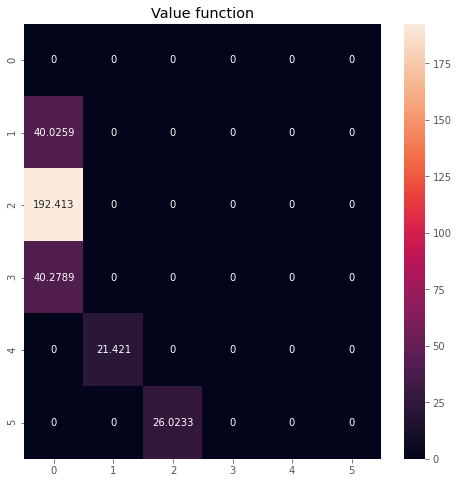

In [384]:
plt.figure(figsize=(8,8))
#df.shape
sns.heatmap(V, annot=True, fmt = 'g')
#plt.savefig('SARSA_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.title('Value function')
plt.show()

Policy 2 to evaluate:  keep the asset without maintenance and replace it at state year 3

In [388]:
# def policy2(state, maint):
#     if state < 3:
#         action = 0
#     else:
#         action = 2
#     return action

In [385]:
policy2 = np.empty((env.n_states, env.n_maint), int)
policy2.fill(-1)
policy2[0:3, 0] = 0
policy2[3,0] = 2
policy2

array([[ 0, -1, -1, -1, -1, -1],
       [ 0, -1, -1, -1, -1, -1],
       [ 0, -1, -1, -1, -1, -1],
       [ 2, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1]])

In [386]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()

# init value function
V = np.zeros((env.n_states, env.n_maint))
# discount factor
discount = 0.9

# evaluate policy
V = evaluate_policy(env, V, policy2, discount)


Episodes endt at25


In [284]:
print(V)

[[  0.           0.           0.           0.           0.        ]
 [119.13033741   0.           0.           0.           0.        ]
 [127.8597786    0.           0.           0.           0.        ]
 [102.06642066   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]


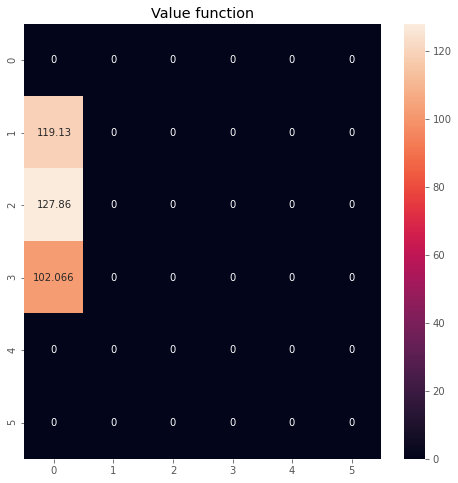

In [387]:
plt.figure(figsize=(8,8))
sns.heatmap(V, annot=True, fmt = 'g')
#plt.savefig('SARSA_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.title('Value function')
plt.show()

# **Policy Iteration**
We implement the policy improvement algorithm to combine it later with the policy evaluation algorithm to create the policy iteration algorithm.

In [566]:
def improve_policy(env, V, policy, gamma):
    """Implements the policy improvement algorithm

    Calculates the greedy policy for a given value function and checks if the 
    new greedy policy changed compared to the old policy

    Args:
        env (class): OpenAI gym environment
        V (numpy.ndarray): A shape-(num_states,) array, contains the value for
            every state
        policy (numpy.ndarray): A shape-(num_states,) array, defines the action
            for every state
        gamma (int): Discount factor
    """

    # save policy to check for convergence later
    old_policy = policy.copy()
    

    # loop through every state and find greedy action
    policy_stable = True


    for state in range(env.n_states):
        for maint in range(env.n_maint):
            if state < maint:
                break
            else:    
                Q = np.zeros(env.n_actions)
                if state== 5:                           
                    policy[state, maint] = 2
                else:
              # find greedy action among possible actions
                    for action in range(env.n_actions):
                        env.state = state
                        env.maint = maint
                        state_next, maint_next, reward = env.step_DP(action)
                        #print(state_next, maint_next, action)
                        Q[action]= reward + discount* V[state_next, maint_next]
                    
                    #print(Q)
                    policy[state, maint] =  np.argmax(Q)


    # check for convergence
    if not np.array_equal(policy, old_policy):
        policy_stable = False
    
    return policy, policy_stable


In [572]:
def policy_iteration(env, discount,policy):
    # init policy and value function
    V = np.zeros((env.n_states,env.n_maint))

    # iterate until policy doesn't change anymore
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, V, policy, discount)
        policy, policy_stable = improve_policy(env, V, policy, discount)

    return V, policy

In [573]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()


# discount factor
discount = 0.9

# use policy1 as initial policy
# apply policy iteration
V, policy = policy_iteration(env, discount, policy1)

Convergence at iteration44


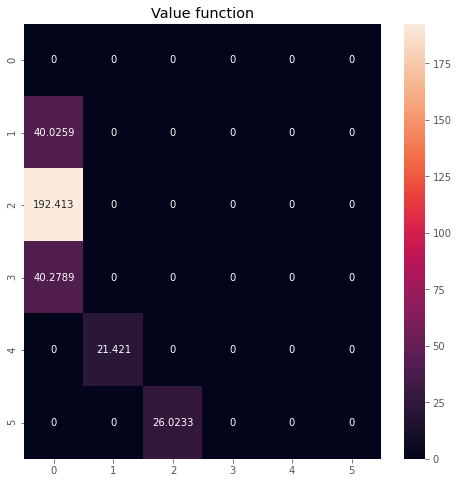

In [574]:
plt.figure(figsize=(8,8))
sns.heatmap(V, annot=True, fmt = 'g')
#plt.savefig('SARSA_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.title('Value function')
plt.show()

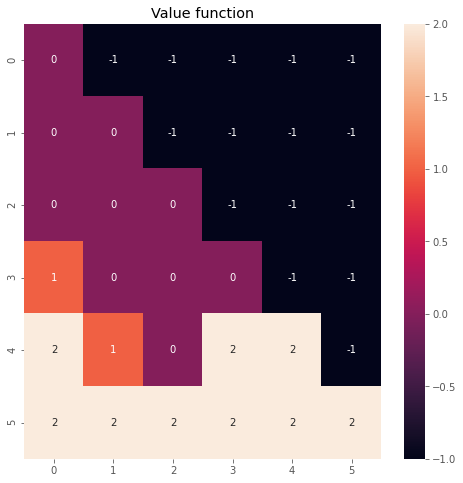

In [575]:
plt.figure(figsize=(8,8))
sns.heatmap(policy, annot=True, fmt = 'g')
#plt.savefig('SARSA_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.title('Value function')
plt.show()

# **Value Iteration**

In [592]:
def value_iteration(env, discount, eps=1e-8, max_iter=1000):
    """Implements the value iteration algorithm

    Calculates the optimal policy and optimal value function

    Args:
        env (class): OpenAI gym environment
        discount (float): Discount factor
        eps (float): Error tolerance
        max_iter (int): Maximum number of iteration
    """
    # initialize value function
    V = np.zeros((env.n_states, env.n_maint))
    # initialize policy (of all states) with -1 
    policy = np.zeros((env.n_states, env.n_maint), int)-1
    
 
    # iterate until value function converges
    for i in range(max_iter):
        V_old = V.copy()
        for state in range(env.n_states):
            for maint in range(env.n_maint):
                    if state < maint:
                        break
                    else:
                        Q = np.zeros(env.n_actions)
                        # determine possible actions for given state
                        for action in range(env.n_actions):
                            env.state = state
                            env.maint = maint
                           
                            if state == 5:
                                action = 2
                            else:
                                pass
                            
                            state_next, maint_next, reward = env.step_DP(action)
                            #print(state_next, maint_next, action)
                            Q[action]= reward + discount* V[state_next, maint_next]

                    V[state, maint] = max(Q)
                    policy[state, maint] =  np.argmax(Q)
        delta = np.linalg.norm(V-V_old)
        if delta < eps:
            break
    print('Convergence at iteration:'+str(i))    
    return V, policy


In [579]:
# The following inplementation of value_iteration is the same as above
# def value_iteration(env, discount, eps=1e-8, max_iter=1000):
#     """Implements the value iteration algorithm

#     Calculates the optimal policy and optimal value function

#     Args:
#         env (class): OpenAI gym environment
#         gamma (int): Discount factor
#         eps (float): Error tolerance
#         max_iter (int): Maximum number of iteration
#     """
#     # initialize value function
#     V = np.zeros((env.n_states, env.n_maint))

#     # iterate until value function converges
#     for i in range(max_iter):
#         V_old = V.copy()
#         for state in range(env.n_states):
#             for maint in range(env.n_maint):
#                     if state < maint:
#                         break
#                     else:
#                         Q = np.zeros(env.n_actions)
#                         # determine possible actions for given state
#                         for action in range(env.n_actions):
#                             env.state = state
#                             env.maint = maint
                           
#                             if state == 5:
#                                 action = 2
#                             else:
#                                 pass
                            
#                             state_next, maint_next, reward = env.step_DP(action)
#                             #print(state_next, maint_next, action)
#                             Q[action]= reward + discount* V[state_next, maint_next]

#                     V[state, maint] = max(Q)
       
#         delta = np.linalg.norm(V-V_old)
#         if delta < eps:
#             break
#     print('Convergence at iteration:'+str(i))    
   
#     # initialize policy (of all states) with -1 
#     policy = np.zeros((env.n_states, env.n_maint), int)-1
    
#     for state in range(env.n_states):
#             for maint in range(env.n_maint):
#                    if state < maint:
#                         break
                   
#                    else: 
#                         Q = np.zeros(env.n_actions)
#                         if state== 5:                           
#                             policy[state, maint] = 2
#                         else:
#                       # find greedy action among possible actions
#                             for action in range(env.n_actions):
#                                 env.state = state
#                                 env.maint = maint
#                                 state_next, maint_next, reward = env.step_DP(action)
#                                 #print(state_next, maint_next, action)
#                                 Q[action]= reward + discount* V[state_next, maint_next]

#                             #print(Q)
#                             policy[state, maint] =  np.argmax(Q)


#     return V, policy


In [593]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()

# discount factor
discount = 0.9

# apply policy iteration
V, policy = value_iteration(env, discount)

Convergence at iteration:144


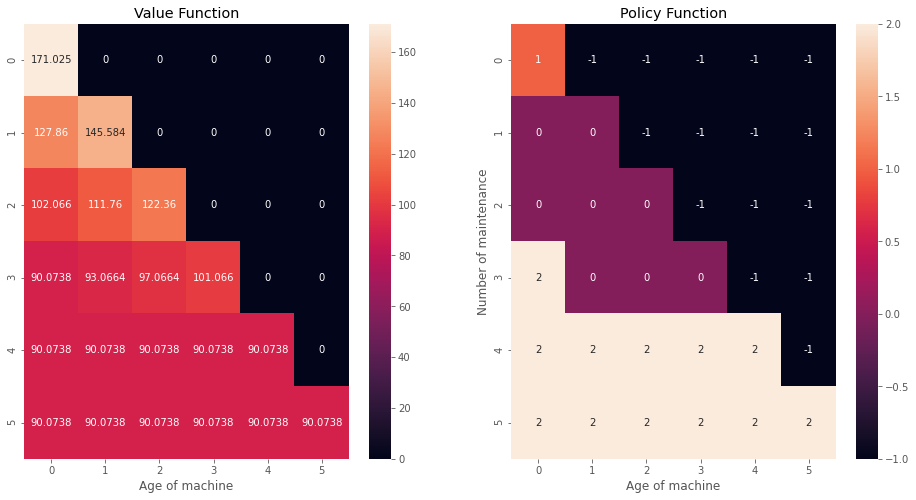

In [598]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_xlabel('Age of machine')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_xlabel('Age of machine')
ax[1].set_ylabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount) +'.pdf')
plt.show()

In [599]:
V_DP = V
policy_DP = policy

Simulate an episode with the optimal policy.

In [600]:
#initialization
state, maint = env.reset()
action = policy_DP[state, maint]
reward = 0
state_path = [state]
maint_path = [maint]
action_path = [action]
reward_path = [reward]

timesteps = 20
for t in range(timesteps):
    state, maint, reward = env.step_DP(action)
    action = policy_DP[state, maint] 
    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)
    reward_path.append(reward)

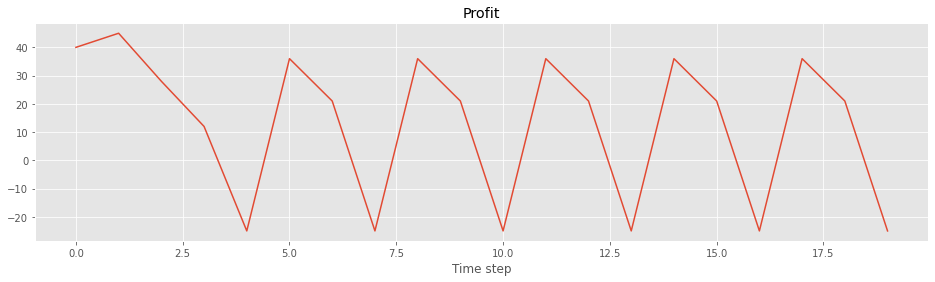

In [601]:
fig = plt.figure(figsize=(16, 4))
plt.plot(reward_path[1:], label='Profit')
plt.title('Profit')
plt.xlabel('Time step')
plt.savefig('DP_Profit' + '-'+ str(discount)+'-'+'.pdf')
plt.show()

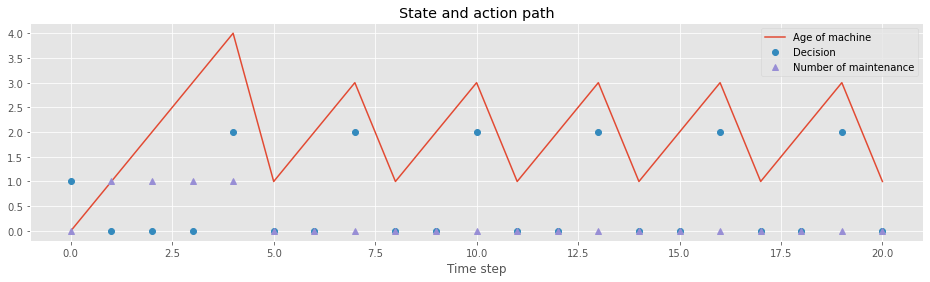

In [602]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, '^', label='Number of maintenance')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.savefig('DP_Path' + '-'+ str(discount)+'-'+'.pdf')
plt.show()

# **Sarsa Agent**

In [811]:
class SarsaAgent():
    def __init__(self, agent_info):
        """Initialize Agent.

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        
        self.rng = default_rng()

        # Create a dict for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))         
       
    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
            next_maint (int):  next state of maintenance failure from environment 
        Returns:
            next_action (int): action the agent takes in next_state
        """

        # choose action using epsilon greedy policy
        action = self.select_action(state, maint)

        # perform update
        target = reward + self.discount*self.q[state, maint][action]
        td_error = target - self.q[self.previous_state,self.previous_maint][self.previous_action]
        self.q[self.previous_state,self.previous_maint][self.previous_action] += self.step_size* td_error
        

        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy.

        Args:
            state (int): Current state, i.e. age of asset.

        Returns:
            action (int): Action the agent takes.
        """

        
        # performe epsilon greedy policy improvement
        # remember to replace asset if age is 5
 #%%%%
        if state== 5:                           # two expression are actually equivalent  
            return 2
        
        if  self.rng.random() < self.epsilon:
            action = self.rng.choice(n_actions)
        else:
            action = self.argmax(self.q[state, maint])
        return action
        
 
    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """
        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)
#         print(ties)
#         print("argmax index:" + str(index))
        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): intial times of maintenance failure
        Returns:
            action (int): initial action
        """

        action = self.select_action(state, maint)

        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action
    




In [862]:
env = AssetReplacementEnv()


epsilon = 0.05
step_size = 0.2
discount = 0.9


agent_info = {"n_actions": env.n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = SarsaAgent(agent_info)

n_episodes = 1000
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        state, maint, fail, reward = env.step(action)
        action = agent.step(reward, state, maint)
#     print('Episodes-'+ str(i)+'-Q value')
#     print(agent.q)    


---

**Evaluation**


---


In [ ]:
# # the norm of difference of value function vary quit lot, after being averaged 5000, it vary within only 5.
# n_avg = 5000
# sum_norm = 0
# for i in range(n_avg):
#     norm = 0
#     state, maint = env.reset()
#     action = agent.start(state, maint)
#     for t in range(timesteps):
#         state, maint, fail, reward = env.step(action)
#         action = agent.step(reward, state, maint)
   
#     V = defaultdict(float)
#     policy = defaultdict(int)
#     for state_maint, values in sorted(agent.q.items()):
#         value = np.max(values)
#         V[state_maint] = value
#         action = np.argmax(values)
#         policy[state_maint] = action  

#     #convert dictionary to array so that we can compare the norm of different value function
#     V_sar = np.zeros((env.n_states, env.n_maint))
#     for k, v in V.items():
#         V_sar[k[0],k[1]] = v
#     norm = np.linalg.norm(V_sar-V_DP)
#     sum_norm += norm

# avg_norm = sum_norm/n_avg
# avg_norm
# print('Norm of difference of value function averaged by another'+ str(n_avg)+' simulation:' + str(avg_norm))

In [ ]:
# # the averaged 20 years profit vary within 20 and increase the size of simulation wont decrease the variation,
# # so it is quite convincing for the evaluation of the agent
# n_avg = 1000
# sum_prof = 0
# for i in range(n_avg):
#     sum_period = 0
#     state, maint = env.reset()
#     action = agent.start(state, maint)
#     fail = 0
#     state_path = [state]
#     maint_path = [maint]
#     action_path = [action]
#     fail_path = [fail]
    
#     for t in range(timesteps):
#         state, maint, fail, reward,  _, _ = env.step(action)
#         action = agent.step(reward, state, maint)
#         state_path.append(state)
#         maint_path.append(maint)
#         action_path.append(action)
#         fail_path.append(fail)
    
#     sum_period = env.sumprofit(state_path, maint_path, action_path, fail_path, timesteps)
#     #print('20 year sum: '+ str(sum_period))
#     sum_prof += sum_period

# avg_prof = sum_prof/n_avg
# avg_prof
# print('Sum of 20 years profit averaged by another '+ str(n_avg)+' simulation:' + str(avg_prof))

In [865]:
# Perform path simulation of episode:  n_episode+1
state, maint = env.reset()
action = agent.start(state, maint)
fail = 0

for t in range(timesteps):
    state, maint, fail, reward = env.step(action)
    action = agent.step(reward, state, maint)
 

In [866]:
# performance = env.sumprofit(state_path, maint_path, action_path, fail_path, timesteps)
# print('Performance of the simulation is: ' + str(performance))

In [867]:
# extract the value function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action


In [868]:
#convert dictionary to array so that we can compare the norm of different value function
V_sar = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_sar[k[0],k[1]] = v
norm = np.linalg.norm(V_sar-V_DP)
norm

249.27343583321908

In [743]:
import pandas as pd
param_perform = {'epsilon': [epsilon],
                'step_size': [step_size],
                'discount': [discount],
                'performance': [avg_norm]}
df_parper = pd.DataFrame (param_perform, columns = ['epsilon','step_size','discount','performance'])
df_parper

,epsilon,step_size,discount,performance
0,0.05,0.2,0.9,147.653916


In [686]:
df_parper_all = df_parper

In [670]:
df_parper_all = df_parper_all.append(df_parper,ignore_index=True)
df_parper_all

,epsilon,step_size,discount,performance
0,0.05,0.2,0.9,244.657266
1,0.05,0.2,0.9,244.657266


In [274]:
#df_stepsize = df_parper
#df_discount = df_parper

In [237]:
#df_discount_all = df_discount

In [167]:
#df_stepsize_all = df_stepsize

In [275]:
df_discount_all = df_discount_all.append(df_discount,ignore_index=True)
df_discount_all

,epsilon,step_size,discount,performance
0,0.2,0.2,0.90,224.000
0,0.2,0.2,0.80,208.985
0,0.2,0.2,0.70,190.525
0,0.2,0.2,0.95,232.710


In [220]:
df_stepsize_all =  df_stepsize_all.append(df_stepsize,ignore_index=True)
df_stepsize_all

,epsilon,step_size,discount,performance
0,0.2,0.05,0.9,205.930
1,0.2,0.10,0.9,220.945
2,0.2,0.20,0.9,221.790
3,0.2,0.30,0.9,220.685



---

**Plot one simulation of best performance**


---

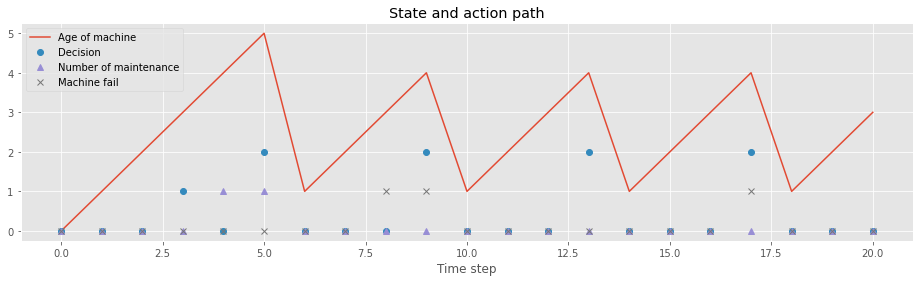

In [623]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, '^', label='Number of maintenance')
plt.plot(fail_path, 'x', label='Machine fail')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.savefig('SARSA_Path' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

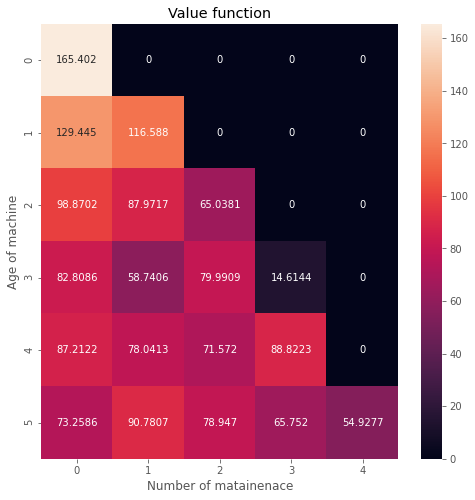

In [628]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Number of matainenace"]))
df = ser.unstack().fillna(0)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.title('Value function')
plt.savefig('SARSA_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

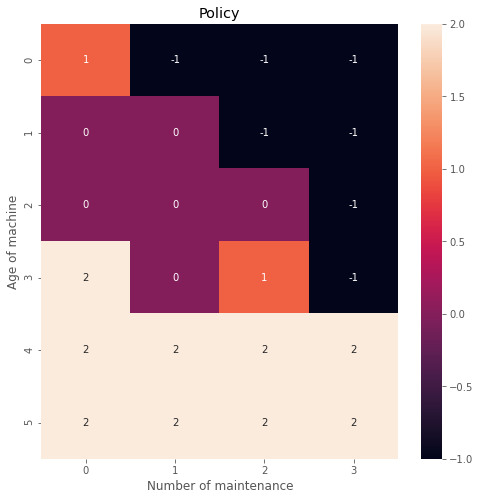

In [537]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Number of maintenance"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.title('Policy')
plt.savefig('SARSA_Policy' +'-' +str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

# **Q-Learning Agent**

In [773]:
class QLearningAgent():
    def __init__(self, agent_info):
        """Initialize Agent

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """
        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        self.rng = default_rng()

        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))      


    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
            next_maint (int):  next state of maintenance failure from environment 
        Returns:
            next_action (int): action the agent takes in next_state
        """

        # choose action using epsilon greedy policy
        action = self.select_action(state, maint)

  
        # perform update
        target = reward + self.discount* np.max(self.q[state, maint])
        td_error = target- self.q[self.previous_state, self.previous_maint][self.previous_action]
        self.q[self.previous_state, self.previous_maint][self.previous_action] += self.step_size * td_error
     

        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy

        Args:
            state (int): current state
            maint (int): current times of maitenance failure
        Returns:
            action (int): action the agent takes
        """
        
        # performe epsilon greedy policy improvement
        # remember to replace asset if age is 5
        if state== 5:
            return 2
        
        if  self.rng.random() < self.epsilon:
            action = self.rng.choice(n_actions)
        else:
            action = self.argmax(self.q[state, maint])
        return action


    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): initial maint
        Returns:
            action (int): initial action
        """

        action = self.select_action(state, maint)

        self.previous_maint= maint
        self.previous_state = state
        self.previous_action = action

        return action


In [869]:
env = AssetReplacementEnv()

epsilon = 0.05
step_size = 0.2
discount = 0.9


agent_info = {"n_actions": env.n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = QLearningAgent(agent_info)

n_episodes = 1000
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)
  
    for t in range(timesteps):
        state, maint,fail, reward, = env.step(action)
        action = agent.step(reward, state, maint)



---

**Evaluation**


---


In [551]:
# # the averaged 20 years profit vary within 20 and increase the size of simulation wont decrease the variation,
# # so it is quite convincing for the evaluation of the agent
# n_avg = 1000
# sum_prof = 0
# for i in range(n_avg):
#     sum_period = 0
#     state, maint = env.reset()
#     action = agent.start(state, maint)

#     for t in range(timesteps):
#         state, maint, reward,  _, _ = env.step(action)
#         action = agent.step(reward, state, maint)
#         state_path.append(state)
#         maint_path.append(maint)
#         action_path.append(action)
    
#     sum_period = env.sumprofit(state_path, maint_path, action_path, timesteps)
#     #print('20 year sum: '+ str(sum_period))
#     sum_prof += sum_period

# avg_prof = sum_prof/n_avg
# avg_prof
# print('Sum of 20 years profit averaged by another '+ str(n_avg)+' simulation:' + str(avg_prof))

Sum of 20 years profit averaged by another 1000 simulation:210.68


In [424]:
import pandas as pd
param_perform = {'epsilon': [epsilon],
                'step_size': [step_size],
                'discount': [discount],
                'performance': [avg_prof]}
df_parper = pd.DataFrame (param_perform, columns = ['epsilon','step_size','discount','performance'])
df_parper

,epsilon,step_size,discount,performance
0,0.5,0.4,0.9,187.21


In [382]:
df_epsilon = df_parper

In [307]:
#df_epsilon_all = df_epsilon

In [ ]:
df_epsilon_all = df_epsilon_all.append(df_epsilon, ignore_index = True)
df_epsilon_all

In [385]:
df_epsilon_all

,epsilon,step_size,discount,performance
0,0.05,0.2,0.9,-20.530
1,0.10,0.2,0.9,58.705
2,0.20,0.2,0.9,135.925
3,0.30,0.2,0.9,171.350
5,0.40,0.2,0.9,184.220
6,0.50,0.2,0.9,196.635
7,0.60,0.2,0.9,192.995
9,0.70,0.2,0.9,194.360


In [425]:
df_stepsize = df_parper


In [396]:
#df_stepsize_all = df_stepsize

In [426]:
df_stepsize_all =  df_stepsize_all.append(df_stepsize,ignore_index=True)
df_stepsize_all

,epsilon,step_size,discount,performance
0,0.5,0.1,0.9,188.640
1,0.5,0.2,0.9,198.195
2,0.5,0.3,0.9,195.205
3,0.5,0.4,0.9,187.210


Summary:  step_size matter not really when it is small, so just take 0.2
          epsilon: around 0.2 the best
          disount: higher seems to be better, but the task require it to be 0.9



---

**Plot one simulation of best performance**


---


In [872]:
# Perform path simulation
state, maint = env.reset()

#agent.epsilon = 0
action = agent.start(state, maint)
reward = 0

state_path = [state]
maint_path = [maint]
action_path = [action]
reward_path = [reward]

timesteps = 20

for t in range(timesteps):
    state, maint, fail, reward= env.step(action)
    action = agent.step(reward, state, maint)
    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)
    reward_path.append(reward)

In [779]:
# performance = env.sumprofit(state_path, maint_path, action_path, fail_path, timesteps)
# print('Performance of the simulation is: ' + str(performance))

In [873]:
# extract the value and policy function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    action = np.argmax(values)
    policy[state_maint] = action
    V[state_maint] = value


In [874]:
V_QL = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_QL[k[0],k[1]] = v
np.linalg.norm(V_QL-V_DP)

257.79400657642003

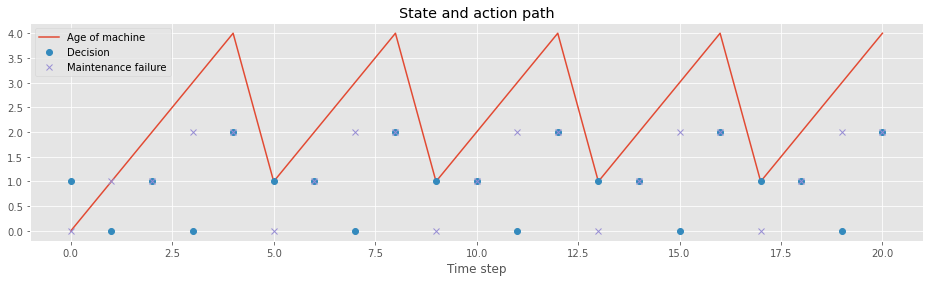

In [452]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, 'x', label='Maintenance failure')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
#plt.savefig('QLearning_Path' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()


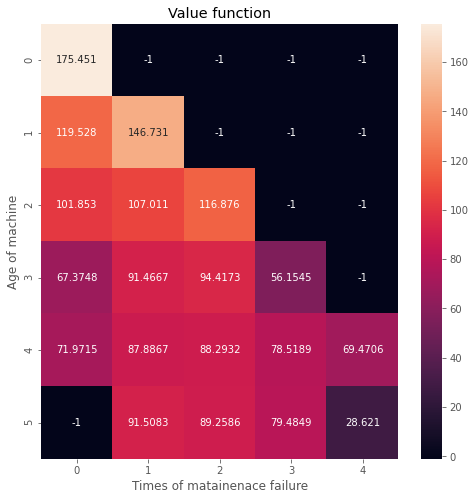

In [453]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.title('Value function')
#plt.savefig('Qlearning_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

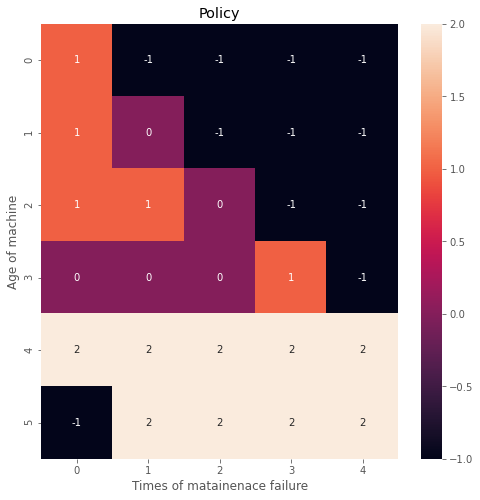

In [454]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.title('Policy')
#plt.savefig('Qlearning_Policy' +'-' +str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

# **Expected Sarsa**

In [879]:
class ExpectedSarsaAgent():
    def __init__(self, agent_info):
        """Initialize Agent.

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        self.rng = default_rng()

        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))        


    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
            next_maint (int):  next state of maintenance failure from environment 
        Returns:
            next_action (int): action the agent takes in next_state
        """

         # choose action using epsilon greedy policy
        action = self.select_action(state, maint)  

        # perform update
        policy = np.ones(self.n_actions)*self.epsilon/self.n_actions
        policy[np.argmax(self.q[state, maint])] += 1 - self.epsilon

       # matrix-vector multiplication
        expectation = self.q[state, maint] @ policy


        target = reward + self.discount * expectation
        td_error = target - self.q[self.previous_state, self.previous_maint][self.previous_action]
        self.q[self.previous_state, self.previous_maint][self.previous_action] += self.step_size * td_error



        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy

        Args:
            state (int): current state
            maint (int): current times of maitenance failure
        Returns:
            action (int): action the agent takes
        """
        if state == 5 or maint == 4:
            return 2

        current_q  = self.q[state, maint]
      
        if self.rng.random() < self.epsilon:
            action = self.rng.choice(self.n_actions)
        else:
            action = self.argmax(current_q)

        return action
        

    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): initial maint
        Returns:
            action (int): initial action
        """

        action = self.select_action(state, maint)

        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

In [883]:
env = AssetReplacementEnv()

num_actions = env.action_space.n
epsilon = 0.05
step_size = 0.2
discount = 0.9


agent_info = {"n_actions": n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = ExpectedSarsaAgent(agent_info)


n_episodes = 1000
timesteps = 20

for _ in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        state, maint, fail, reward= env.step(action)
        action = agent.step(reward, state, maint)



---

**Evaluation**


---

In [801]:
# the averaged 20 years profit vary within 20 and increase the size of simulation wont decrease the variation,
# so it is quite convincing for the evaluation of the agent
n_avg = 1000
sum_prof = 0
for i in range(n_avg):
    sum_period = 0
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        state, maint, reward,  _, _ = env.step(action)
        action = agent.step(reward, state, maint)
        state_path.append(state)
        maint_path.append(maint)
        action_path.append(action)
    
    sum_period = env.sumprofit(state_path, maint_path, action_path, timesteps)
    #print('20 year sum: '+ str(sum_period))
    sum_prof += sum_period

avg_prof = sum_prof/n_avg
avg_prof
print('Sum of 20 years profit averaged by another '+ str(n_avg)+' simulation:' + str(avg_prof))

Sum of 20 years profit averaged by another 1000 simulation:158.41


In [796]:
import pandas as pd
param_perform = {'epsilon': [epsilon],
                'step_size': [step_size],
                'discount': [discount],
                'performance': [avg_prof]}
df_parper = pd.DataFrame (param_perform, columns = ['epsilon','step_size','discount','performance'])
df_parper

,epsilon,step_size,discount,performance
0,0.7,0.2,0.9,138.775


In [797]:
df_epsilon = df_parper

In [731]:
#df_epsilon_all = df_epsilon

In [798]:
df_epsilon_all = df_epsilon_all.append(df_epsilon, ignore_index = True)
df_epsilon_all

,epsilon,step_size,discount,performance
0,0.05,0.2,0.9,-60.930
1,0.10,0.2,0.9,-12.200
2,0.20,0.2,0.9,61.555
3,0.30,0.2,0.9,90.375
4,0.40,0.2,0.9,146.365
5,0.50,0.2,0.9,158.740
6,0.60,0.2,0.9,149.830
7,0.70,0.2,0.9,138.775



---

**Plot one simulation of best performance**


---


In [887]:
# Perform path simulation
state, maint = env.reset()
action = agent.start(state, maint)

state_path = [state]
maint_path = [maint]
action_path = [action]

for t in range(timesteps):
    state, maint, fail,reward = env.step(action)
    action = agent.step(reward, state, maint)

    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)

In [ ]:
# performance = env.sumprofit(state_path, maint_path, action_path, timesteps)
# print('Performance of the simulation is: ' + str(performance))

In [888]:
# extract the value and policy function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action
    

In [889]:
V_ExSa = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_ExSa[k[0],k[1]] = v
np.linalg.norm(V_ExSa-V_DP)

277.5724027877359

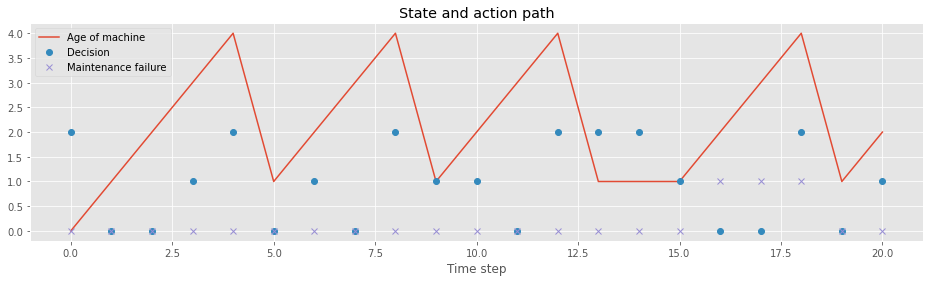

In [835]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, 'x', label='Maintenance failure')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.savefig('ExSarsa_Path' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()


In [34]:
V

defaultdict(float,
            {(0, 0): 84.1222002808312,
             (1, 0): 47.140063537104865,
             (2, 0): 16.050853970239025,
             (2, 1): 39.58283698273672,
             (3, 0): 23.162983296941466,
             (3, 1): 23.766612519509792,
             (3, 2): 16.647856193434432,
             (4, 0): 25.919437153578343,
             (4, 1): 15.263270048004747,
             (4, 2): 20.82652075434692,
             (4, 3): 7.713690573523174,
             (5, 1): 7.7519884973199265,
             (5, 2): 14.818426693101566,
             (5, 3): 12.420384946020565})

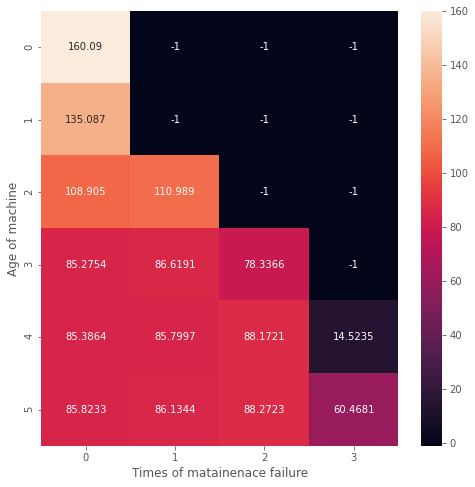

In [837]:

plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.savefig('ExSarsa_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

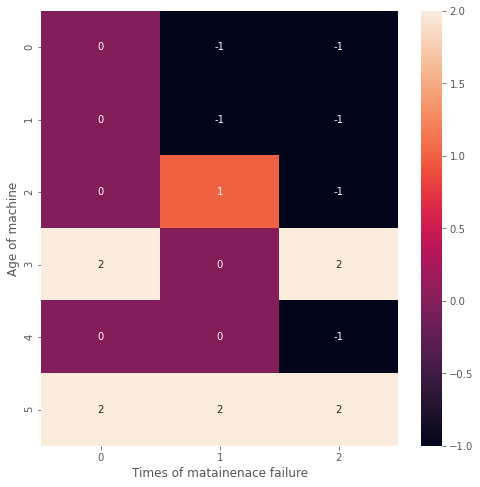

In [103]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.savefig('ExSarsa_Policy' +'-' +str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

In [34]:
X =  np.array([x[0] for x in list(V.keys())])

In [35]:
Y = np.array([x[1] for x in list(V.keys())])

In [36]:
Z = np.array( list(V.values()))

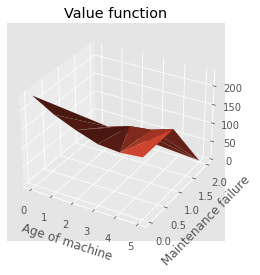

In [38]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(X,Y,Z)
ax.set_title('Value function')
ax.set_xlabel('Age of machine')
ax.set_ylabel( 'Maintenance failure')
plt.show()